# Mount Drive

In [42]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [98]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [71]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [72]:
import pandas as pd

DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/fake_reviews_dataset.csv"
df = pd.read_csv(DATASET_PATH)

df.head()


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [73]:
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


Index(['category', 'rating', 'label', 'text_'], dtype='object')

In [74]:
df['category'].value_counts()
df['label'].value_counts()


,count
label,
CG,20216
OR,20216


In [84]:

df['label_binary'] = df['label'].map({'CG': 0, 'OR': 1})



In [85]:
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])
num_classes = df['category_encoded'].nunique()


# Preprocessing the text (Tokenization,lemma)

In [86]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_review'] = df['text_'].apply(clean_text)


In [87]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X = tfidf.fit_transform(df['clean_review']).toarray()


# Training Multiclass Classifier

In [88]:
y_cat = to_categorical(df['category_encoded'], num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=df['category_encoded']
)


In [89]:
model_mc = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_mc.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_mc.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,442 (5.01 MB)

 Trainable params: 1,314,442 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
history_mc = model_mc.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.5200 - loss: 1.3931 - val_accuracy: 0.7669 - val_loss: 0.6557
Epoch 2/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8161 - loss: 0.5400 - val_accuracy: 0.7759 - val_loss: 0.6471
Epoch 3/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.8635 - loss: 0.3964 - val_accuracy: 0.7635 - val_loss: 0.6997
Epoch 4/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.8932 - loss: 0.3066 - val_accuracy: 0.7703 - val_loss: 0.7455
Epoch 5/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9206 - loss: 0.2308 - val_accuracy: 0.7638 - val_loss: 0.8130
Epoch 6/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9415 - loss: 0.1768 - val_accuracy: 0.7586 - val_loss: 0.9200
Epoch 7/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9573 - loss: 0.1292 - val_accuracy: 0.7601 - val_loss: 1.0186
Epoch 8/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9669 - loss: 0.1024 - 

# Task 1

In [91]:
y_pred_mc = model_mc.predict(X_test)
y_pred_labels = np.argmax(y_pred_mc, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                              precision    recall  f1-score   support

                     Books_5       0.75      0.71      0.73       874
Clothing_Shoes_and_Jewelry_5       0.79      0.76      0.78       770
               Electronics_5       0.77      0.79      0.78       798
          Home_and_Kitchen_5       0.69      0.69      0.69       811
              Kindle_Store_5       0.77      0.78      0.78       946
             Movies_and_TV_5       0.88      0.89      0.89       717
              Pet_Supplies_5       0.85      0.84      0.85       851
       Sports_and_Outdoors_5       0.58      0.60      0.59       789
Tools_and_Home_Improvement_5       0.65      0.68      0.66       772
            Toys_and_Games_5       0.82      0.81      0.82       759

                    accuracy                           0.75      8087
                   macro avg       0.76      0.76      0.76      8087
                weighted avg       0.76      0.

# Fake review

In [92]:
y_bin = df['label_binary'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin,
    test_size=0.2,
    random_state=42,
    stratify=y_bin
)


In [93]:
model_bin = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_bin.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_bin.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,281 (5.01 MB)

 Trainable params: 1,313,281 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
history_bin = model_bin.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.8042 - loss: 0.3989 - val_accuracy: 0.8924 - val_loss: 0.2473
Epoch 2/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9289 - loss: 0.1732 - val_accuracy: 0.8918 - val_loss: 0.2535
Epoch 3/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9529 - loss: 0.1179 - val_accuracy: 0.8980 - val_loss: 0.2700
Epoch 4/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9726 - loss: 0.0756 - val_accuracy: 0.8946 - val_loss: 0.3246
Epoch 5/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9813 - loss: 0.0477 - val_accuracy: 0.8934 - val_loss: 0.4256
Epoch 6/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9911 - loss: 0.0259 - val_accuracy: 0.8912 - val_loss: 0.4937
Epoch 7/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9938 - loss: 0.0170 - val_accuracy: 0.8949 - val_loss: 0.5625
Epoch 8/10
910/910 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9952 - loss: 0.0132 - 

In [95]:
y_pred_bin = (model_bin.predict(X_test) > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred_bin))
print(classification_report(y_test, y_pred_bin))


253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[[3677  367]
 [ 493 3550]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      4044
           1       0.91      0.88      0.89      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



# Task 2

In [97]:
df['label_binary'] = df['label'].map({'CG': 0, 'OR': 1})

fake_counts = df[df['label_binary'] == 1]['category'].value_counts()
print(fake_counts)


category
Kindle_Store_5                  2365
Books_5                         2185
Pet_Supplies_5                  2127
Home_and_Kitchen_5              2028
Electronics_5                   1994
Sports_and_Outdoors_5           1973
Tools_and_Home_Improvement_5    1929
Clothing_Shoes_and_Jewelry_5    1924
Toys_and_Games_5                1897
Movies_and_TV_5                 1794
Name: count, dtype: int64


# Word Cloud

# Task 3

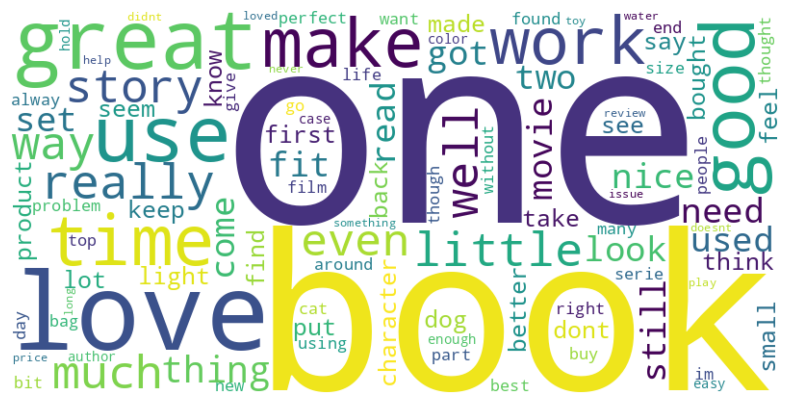

In [96]:
from wordcloud import WordCloud

fake_text = " ".join(df[df['label_binary'] == 1]['clean_review'])

wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
)

plt.figure(figsize=(10,5))
plt.imshow(wc.generate(fake_text), interpolation='bilinear')
plt.axis('off')
plt.show()
